In [52]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import BayesianRidge

warnings.filterwarnings('ignore')

import pandas as pd


In [23]:
file_paths = [
    r"C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\dataset\AML_output_3.csv",
    r"C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\dataset\ccRCC_output_3.csv",
    r"C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\dataset\chRCC_output_3.csv",
    r"C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\dataset\pRCC_output_3.csv",
    r"C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\dataset\RO_output_3.csv"
]

dataframes = [pd.read_csv(file, index_col=0) for file in file_paths]

dataset_labels = ['benign', 'ccRCC', 'nccRCC', 'nccRCC', 'benign']

In [24]:
dataframes = []
for file, label in zip(file_paths, dataset_labels):
    df = pd.read_csv(file)
    df['Dataset_Type'] = label
    dataframes.append(df)

In [33]:
for i, df in enumerate(dataframes):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

dataframes[0].columns

Index(['25-羟基维生素D(VITD)', 'ABO血型', 'ACR比值', 'B型钠尿肽', 'B淋巴细胞(CD3-CD19+)',
       'B淋巴细胞绝对值', 'C-反应蛋白', 'CD20+淋巴细胞百分比（CD45+CD3-CD20+/LYM%）',
       'CD3+HLA-DR+/CD3+(%)', 'CD4+CD38+/CD4+(%)',
       ...
       '高密度脂蛋白胆固醇(HDL)', 'Ts淋巴细胞  CD8', '尿白细胞', '尿糖', '尿素氮(BUN)', '尿蛋白',
       '钠(NA)', '镁(MG)', '尿素氮', 'Dataset_Type'],
      dtype='object', length=292)

In [34]:
common_columns = set(dataframes[0].columns)
for df in dataframes[1:]:
    common_columns &= set(df.columns)

# Ensure columns are ordered consistently
ordered_common_columns = [col for col in dataframes[0].columns if col in common_columns]

# Retain only common columns initially
filtered_dataframes = [df[ordered_common_columns].copy() for df in dataframes]

In [35]:
synonym_dict = {
    '丙肝抗体(C)': '丙肝抗体',
    '乙肝E抗体': '乙肝e抗体(YP)',
    '乙肝E抗原': '乙肝e抗原(YP)',
    '乙肝核心抗体': '乙肝核心抗体(YP)',
    '乙肝表面抗体': '乙肝表面抗体(YP)',
    '乙肝表面抗原': '乙肝表面抗原(YP)',
    '梅毒螺旋体抗体': '梅毒确诊试验',
    '梅毒甲苯胺红不加热血清试验(TRUST)': '梅毒确诊试验',
    'Th淋巴细胞(CD3+CD4+)': 'Th淋巴细胞CD4',
    'Th淋巴细胞（CD3+CD4+）': 'Th淋巴细胞CD4',
    'Ts淋巴细胞  CD8': 'Ts淋巴细胞CD8',
    'Ts淋巴细胞(CD3+CD8+)': 'Ts淋巴细胞CD8',
    'CD8+CD38+': 'Ts淋巴细胞CD8',
    'T淋巴细胞（CD3+）': 'T淋巴细胞(CD3+)',
    'T淋巴细胞CD3': 'T淋巴细胞(CD3+)',
    'B淋巴细胞（CD3-CD19+）': 'B淋巴细胞(CD3-CD19+)',
    'B淋巴细胞CD19': 'B淋巴细胞(CD3-CD19+)',
    '淋巴细胞绝对值（CD45+）': '淋巴细胞绝对值',
    '淋巴细胞绝对值（CD45）': '淋巴细胞绝对值',
    '自然杀伤细胞(CD3-CD16+CD56+)': '自然杀伤细胞CD56+CD16',
    'CD3+HLA-DR+': 'CD3+HLA-DR+/CD3+(%)',
    'CD8+HLA-DR+': 'CD8+HLA-DR+/CD8+(%)',
    'INF-r': 'γ干扰素',
    'IFN-γ': 'γ干扰素',
    'IFN-α': 'α干扰素',
    'IL-6': '白细胞介素-6',
    '白介素-6(IL-6)': '白细胞介素-6',
    'IL-12P70': '白细胞介素-12p70',
    'IL-1β': '白细胞介素-1β',
    'IL-5': '白细胞介素-5',
    'IL-8': '白细胞介素-8',
    'C反应蛋白': 'C-反应蛋白',
    '肌酸激酶同工酶(质量法)': '肌酸激酶同工酶',
    '肌酸激酶': '肌酸激酶(CK)',
    '真菌': '酵母菌',
    '尿沉渣上皮细胞': '尿上皮细胞计数',
    '尿沉渣白细胞': '尿沉渣白细胞计数',
    '尿沉渣红细胞': '尿沉渣红细胞计数',
    '病理管型': '病理性管型',
    '白细胞': '镜检白细胞',
    '管型': '镜检管型',
    '红细胞': '镜检红细胞',
    '总蛋白': '总蛋白(TP)',
    '白球比例': '白球比例(A:G)',
    'eGFR-EPIcysc': '胱抑素C(CysC)',
    '尿白蛋白肌酐比': 'ACR比值',
    '尿素氮': '尿素氮(BUN)',
    '葡萄糖(GLU)': '空腹血糖(GLU)',
    '血小板最大聚集率': '血小板最大聚集率(AA)',
    '血小板粘附率': '血小板粘附率(AA)',
    '异常红细胞形态检测': '异常红细胞形态检测(AA)',
    '异常血小板形态检测': '异常血小板形态检测(AA)',
    '血小板计数初始值': '血小板计数初始值(AA)',
    '红细胞平均体积初始': '红细胞计数初始值(AA)',
    '红细胞计数初始值': '红细胞计数初始值(ADP)',
}

In [36]:
standardized_dfs = [df.rename(columns=synonym_dict) for df in filtered_dataframes]

In [37]:
for i, df in enumerate(standardized_dfs):
    df = df.loc[:, ~df.columns.duplicated()]
    standardized_dfs[i] = df

In [38]:
merged_df = pd.concat(standardized_dfs, ignore_index=True)

missing_threshold = 0.25
filtered_df = merged_df.loc[:, merged_df.isnull().mean() <= missing_threshold]

In [39]:
filtered_df.columns

Index(['25-羟基维生素D(VITD)', 'ABO血型', 'C-反应蛋白', 'D-D二聚体', 'HIV Ag/Ab', 'Rh(C)血型',
       'Rh(D)血型', 'Rh(E)血型', 'TEG凝血因子活性', 'TEG纤溶系统',
       ...
       '部分凝血活酶时间', '钙(CA)', '钠(Na)', '钾(K)', '铁蛋白', '镁(Mg)', '镜检白细胞', '镜检红细胞',
       '预测纤溶指标', 'Dataset_Type'],
      dtype='object', length=111)

In [66]:
filtered_df.to_csv(r'C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\output\checkpoint_merged_df.csv', encoding = 'utf-8-sig', index=False)

In [42]:
# ------------------- STEP 1: Basic Symbol Cleaning -------------------
filtered_df.replace({'<': '', '>': '', '╋': '阳性'}, regex=True, inplace=True)
filtered_df.replace({'未查见': 0, '': 0}, inplace=True)

# ------------------- STEP 2: Auto-Detect Column Types -------------------

def is_numeric(val):
    try:
        float(str(val).strip())
        return True
    except:
        return False

numeric_cols = [col for col in filtered_df.columns if filtered_df[col].apply(is_numeric).mean() > 0.8]
categorical_cols = [col for col in filtered_df.columns if col not in numeric_cols]

if "尿微量白蛋白" in categorical_cols:
    categorical_cols.remove("尿微量白蛋白")
    numeric_cols.append("尿微量白蛋白")

# ------------------- STEP 3: Clean Numeric Columns -------------------
def clean_numeric_value(x):
    x = str(x).strip()
    if re.match(r'^\d+\-\d+$', x):
        x = x.split('-')[0].strip()
    if ',' in x:
        x = x.split(',')[-1].strip()
    try:
        cleaned_val = re.sub(r'[^\d.]', '', x)
        return float(cleaned_val) if cleaned_val else 0.0
    except:
        return 0.0

for col in numeric_cols:
    filtered_df[col] = filtered_df[col].apply(clean_numeric_value)

# ------------------- STEP 4: Clean Categorical Columns -------------------
def clean_categorical_value(x):
    x = str(x).strip()
    if '阴性' in x or '-' in x or 'neg' in x:
        return '阴性'
    elif '阳性' in x or '+' in x or '±' in x or 'norm' in x or 'normal' in x:
        return '阳性'
    elif '正常' in x:
        return '正常'
    elif x == '':
        return np.nan
    return x  # Keep original if it doesn't match any pattern

for col in categorical_cols:
    filtered_df[col] = filtered_df[col].apply(clean_categorical_value)

# ------------------- STEP 5: Re-Classify Columns -------------------
numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object']).columns.tolist()


In [43]:
scaler = StandardScaler()
filtered_df[numeric_cols] = scaler.fit_transform(filtered_df[numeric_cols])

filtered_df[categorical_cols]

,ABO血型,HIV Ag/Ab,Rh(C)血型,Rh(D)血型,Rh(E)血型,TEG凝血因子活性,TEG纤溶系统,TEG纤维蛋白原水平,TEG血小板功能,丙型肝炎病毒核心抗原,...,尿白细胞酯酶,尿胆原,尿胆红素,尿葡萄糖,尿蛋白质,尿酮体,尿颜色,抗体筛选,检测类型,Dataset_Type
0,B,阴性,阳性,阳性,阳性,正常,正常,正常,正常,阴性,...,阴性,阳性,阴性,阴性,阳性,阴性,琥珀色,阴性,普通检测,benign
1,B,阴性,阳性,阳性,阳性,正常,正常,正常,正常,阴性,...,阴性,阳性,阴性,阴性,阴性,阴性,稻黄色,阴性,普通检测,benign
2,B,阴性,阴性,阳性,阳性,正常,正常,正常,正常,阴性,...,阴性,阳性,阴性,阴性,阴性,阴性,稻黄色,阴性,普通检测,benign
3,B,阴性,阳性,阳性,阴性,正常,正常,正常,正常,阴性,...,阴性,阳性,阴性,阳性,阴性,阴性,浅黄色,阴性,普通检测,benign
4,A,阴性,阳性,阳性,阳性,正常,正常,正常,增高,阴性,...,阴性,阳性,阴性,阴性,阴性,阴性,稻黄色,阴性,普通检测,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,O,阴性,阳性,阳性,阴性,正常,正常,增高,正常,阴性,...,阴性,阳性,阴性,阴性,阳性,阴性,nan,阴性,普通检测,benign
773,A,阴性,阳性,阳性,阴性,nan,nan,nan,nan,阴性,...,阴性,阳性,阴性,阴性,阴性,阴性,nan,阴性,nan,benign
774,A,阴性,阳性,阳性,阴性,正常,正常,正常,正常,nan,...,阴性,阳性,阴性,阴性,阳性,阴性,稻黄色,nan,普通检测,benign
775,A,阴性,阳性,阳性,阳性,正常,正常,正常,正常,阴性,...,阳性,阳性,阴性,阴性,阴性,阴性,稻黄色,阴性,普通检测,benign


In [47]:
output_dir = r'C:\Users\user\Documents\RCC_Project\kidneytumor_project\Preprocessing\output'
# Save the DataFrame to a CSV file
filtered_df.to_csv(os.path.join(output_dir, 'checkpoint_cleaned_df.csv'), encoding='utf-8-sig', index=False)

In [48]:
numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object']).columns.tolist()

In [50]:
# Apply one hot encoding to categorical columns
encoder = OneHotEncoder(sparse_output=False, dtype=int)
encoded_array = encoder.fit_transform(filtered_df[categorical_cols])

encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
final_df = pd.concat([filtered_df[numeric_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

final_df.to_csv(os.path.join(output_dir, 'preprocessed_df.csv'), encoding='utf-8-sig', index=False)

In [ ]:
# Separate features and target variable
y_cols = ['Dataset_Type_benign', 'Dataset_Type_ccRCC', 'Dataset_Type_nccRCC']
X = final_df.drop(columns=y_cols, errors='ignore')
y = final_df[y_cols] if all(col in final_df.columns for col in y_cols) else None

# Apply PCA
pca = PCA(n_components=0.95) # Retain 95% of variance
pca_result = pca.fit_transform(X)

In [58]:
# Extract Eigenvalues (variance explained by each PC)
eigenvalues = pca.explained_variance_

# Create a DataFrame for eigenvalues and their explained variance ratio
eigenvalues_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues,
    'Explained Variance Ratio': pca.explained_variance_ratio_
})

In [68]:
eigenvalues_df.to_csv(os.path.join(output_dir, 'pca_eigenvalues.csv'), encoding='utf-8-sig', index=False)
eigenvalues_df.head()

,Principal Component,Eigenvalue,Explained Variance Ratio
0,PC1,11.510298,0.122656
1,PC2,6.867122,0.073178
2,PC3,6.411873,0.068326
3,PC4,5.401178,0.057556
4,PC5,3.898171,0.041540


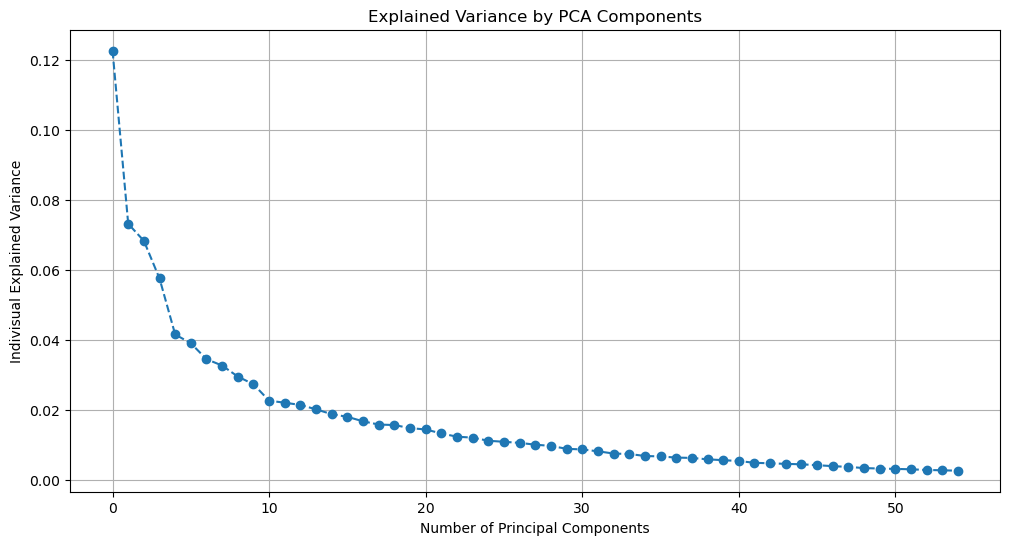

In [67]:
# Plot Explained indivisual variance
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Indivisual Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [70]:
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=X.columns)

top_features = {}
for i in range(20):
    component = f'PC{i+1}'
    sorted_loadings = loadings[component].abs().sort_values(ascending=False)
    top_features[component] = sorted_loadings.head(10).index.tolist()

top_features_df = pd.DataFrame.from_dict(top_features, orient='index').transpose()

In [71]:
top_features_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,总蛋白(TP),平均血红蛋白浓度,糖类抗原(CA19-9),红细胞沉降率ESR,凝血酶原时间,凝固时间,血小板计数,嗜酸性粒细胞百分比,D-D二聚体,纤维蛋白(原)降解物,预测纤溶指标,有核红细胞百分比,谷氨酸脱氢酶(GLDH),纤溶指标,纤维蛋白(原)降解物,甘胆酸(CG),甘胆酸(CG),大血小板比率,淋巴细胞绝对值,尿酸碱度
1,白蛋白(ALB),血小板功能,直接胆红素(DBIL),纤维蛋白原,国际标准化比率,血小板功能,嗜碱性粒细胞绝对值,嗜酸性粒细胞绝对值,镁(Mg),D-D二聚体,纤溶指标,有核红细胞绝对值,肌酐(CREA),预测纤溶指标,D-D二聚体,尿B2-微球蛋白,尿B2-微球蛋白,血小板分布宽度,淋巴细胞百分比,尿比重
2,平均血红蛋白浓度,镁(Mg),糖类抗原(CA125),C-反应蛋白,部分凝血活酶时间,纤维蛋白原水平,血小板比积,嗜碱性粒细胞绝对值,纤维蛋白(原)降解物,嗜中性粒细胞绝对值,单核细胞百分比,大血小板比率,γ谷氨酰基转移酶(GGT),尿a1-微球蛋白,钠(Na),尿酸碱度,D-D二聚体,单核细胞绝对值,嗜碱性粒细胞百分比,嗜酸性粒细胞百分比
3,平均红细胞体积,凝固时间,丙氨酸氨基转移酶(ALT),总胆红素(TBIL),胱抑素C(CysC),凝血因子活性,淋巴细胞绝对值,嗜碱性粒细胞百分比,25-羟基维生素D(VITD),尿微量白蛋白,尿转铁蛋白,血小板分布宽度,嗜中性粒细胞绝对值,尿B2-微球蛋白,大血小板比率,尿比重,纤维蛋白(原)降解物,尿转铁蛋白,镜检白细胞,甘胆酸(CG)
4,球蛋白(GLB),平均血红蛋白量,总胆红素(TBIL),直接胆红素(DBIL),肌酐(CREA),纤维蛋白原水平min,纤维蛋白(原)降解物,嗜中性粒细胞百分比,钙(CA),大血小板比率,尿微量白蛋白,血小板计数,红细胞压积,红细胞压积,肌酐(CREA),尿a1-微球蛋白,淋巴细胞百分比,单核细胞百分比,单核细胞百分比,淋巴细胞绝对值
5,平均血红蛋白量,平均红细胞体积,天门冬氨酸氨基转移酶(AST),糖类抗原(CA19-9),尿微量白蛋白,血块强度,纤维蛋白原水平min,肌酐(CREA),尿a1-微球蛋白,白细胞计数,有核红细胞百分比,嗜中性粒细胞百分比,淋巴细胞百分比,尿转铁蛋白,血小板分布宽度,预测纤溶指标,空腹血糖(GLU),甘胆酸(CG),谷氨酸脱氢酶(GLDH),尿a1-微球蛋白
6,血红蛋白,钙(CA),癌胚抗原(CEA),丙氨酸氨基转移酶(ALT),尿素(UREA),尿比重,嗜碱性粒细胞百分比,总蛋白(TP),尿B2-微球蛋白,尿转铁蛋白,铁蛋白,单核细胞百分比,胱抑素C(CysC),尿免疫球蛋白G,嗜碱性粒细胞绝对值,纤溶指标,纤溶指标,尿免疫球蛋白G,空腹血糖(GLU),谷氨酸脱氢酶(GLDH)
7,红细胞计数,钠(Na),总胆汁酸(TBA),血块强度,凝血酶时间,尿酸碱度,D-D二聚体,淋巴细胞绝对值,磷(PHOS),血小板分布宽度,C-反应蛋白,红细胞压积,尿免疫球蛋白G,凝血酶时间,平均血小板体积,总胆汁酸(TBA),预测纤溶指标,肌酐(CREA),甘胆酸(CG),嗜酸性粒细胞绝对值
8,前白蛋白(PA),平均血小板体积,γ谷氨酰基转移酶(GGT),天门冬氨酸氨基转移酶(AST),前白蛋白(PA),凝血综合参数,嗜中性粒细胞百分比,球蛋白(GLB),凝血酶原时间,平均血小板体积,尿免疫球蛋白G,平均血小板体积,尿转铁蛋白,有核红细胞绝对值,镜检白细胞,尿微量白蛋白,磷(PHOS),平均血小板体积,嗜中性粒细胞百分比,嗜碱性粒细胞百分比
9,红细胞分布宽度SD,凝血因子活性,白球比例(A:G),总胆汁酸(TBA),谷氨酸脱氢酶(GLDH),镁(Mg),尿微量白蛋白,淋巴细胞百分比,国际标准化比率,纤维蛋白原水平,尿酸碱度,预测纤溶指标,白细胞计数,有核红细胞百分比,血红蛋白,淋巴细胞百分比,尿a1-微球蛋白,γ谷氨酰基转移酶(GGT),嗜碱性粒细胞绝对值,尿免疫球蛋白G


In [72]:
# Convert reduced data to tensor
pca_tensor_data = torch.tensor(pca_result, dtype=torch.float32)

torch.save(pca_tensor_data, 'pca_tensor_data.pt')

print(f"Original Feature Count: {final_df.shape[1]}")
print(f"Reduced Feature Count after PCA: {pca_tensor_data.shape[1]}")
print(f"Tensor Shape for Training: {pca_tensor_data.shape}")

Original Feature Count: 184
Reduced Feature Count after PCA: 55
Tensor Shape for Training: torch.Size([777, 55])
